# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import sys, os

import model
from utils import plot_images
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# # Train Phase transformations

train_transforms = transforms.Compose([
                                      #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       #transforms.Resize((28, 28)),
                                       transforms.RandomAutocontrast(p=0.1),
                                       transforms.RandomRotation((-7., 7.), fill=1),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
                            
        
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                       ])


# Test Phase transformations
inv_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                                                            std=[1/0.229, 1/0.224, 1/0.255]),
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
print (train)
print (test)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAutocontrast(p=0.1)
               RandomRotation(degrees=[-7.0, 7.0], interpolation=nearest, expand=False, fill=1)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
print (len(train_loader))
print (len(test_loader))

CUDA Available? True
782
157


TRAIN DATASET


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

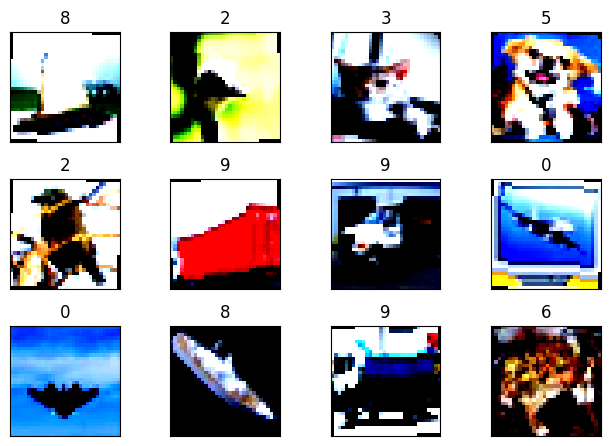

In [6]:
print ("TRAIN DATASET")
batch_data_train, batch_label_train = next(iter(train_loader)) 
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("train_dataset.jpg")

TEST DATATEST


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

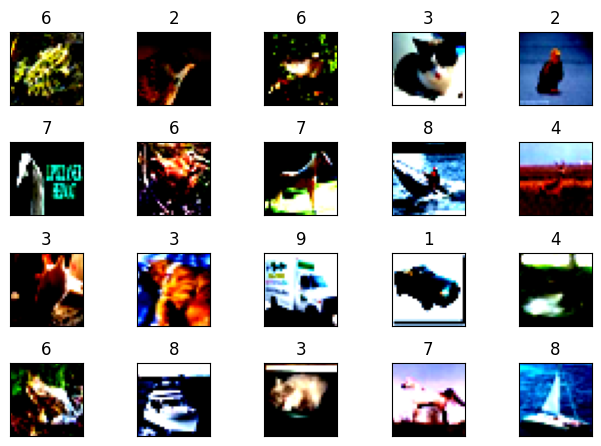

In [7]:
print ('TEST DATATEST')
batch_data_test, batch_label_test = next(iter(test_loader)) 
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_train.savefig("test_dataset.jpg")

In [8]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
        
    print (" TRAIN ACCURACY: ",100*correct/processed, "TRAIN LOSS: ", loss.item()),

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            

            
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            
#             for i in pred.tolist()[0]:
#                 print (i)
#                 #if (pred.eq(target.view_as(pred)) == False):
#                 #    print (i)
            
#             print (pred.eq(target.view_as(pred)))
# #             if (pred.eq(target.view_as(pred)) ==  False):
# #                 print ()
#             print (target)
#             print (pred.tolist())
#             print (type(pred))
#             transfom = pred.ToPILImage()
#             pred_new = inv_transforms(transfom)
            
#             print ("***********pred_new**********")
#             print (pred_new)
                      
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
     #   test_loss, correct, len(test_loader.dataset),
      #  100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    print (" TEST ACCURACY: ",100*correct/len(test_loader.dataset), "TEST LOSS: ", test_loss)
    
def plot_losses(train_losses, train_acc, test_losses, test_acc, name):
    t = [t_items.item() for t_items in train_losses]
    %matplotlib inline
    
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")
    fig.savefig(name+'.jpg')

# Model Params for Batch Normalization
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
m = model.Net_batch_normalization().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
              ReLU-2           [-1, 48, 32, 32]               0
       BatchNorm2d-3           [-1, 48, 32, 32]              96
         Dropout2d-4           [-1, 48, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          20,784
              ReLU-6           [-1, 48, 32, 32]               0
       BatchNorm2d-7           [-1, 48, 32, 32]              96
         Dropout2d-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,568
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

In [11]:
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1, verbose=False)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch),
    train(m, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(m, device, test_loader)

EPOCH: 0


100% 782/782 [00:04<00:00, 163.87it/s]

 TRAIN ACCURACY:  42.506 TRAIN LOSS:  1.4310606718063354


 TEST ACCURACY:  52.38 TEST LOSS:  1.2863776294708251
EPOCH: 1


100% 782/782 [00:03<00:00, 206.96it/s]

 TRAIN ACCURACY:  56.388 TRAIN LOSS:  1.5007870197296143


 TEST ACCURACY:  60.71 TEST LOSS:  1.056258427810669
EPOCH: 2


100% 782/782 [00:03<00:00, 200.52it/s]

 TRAIN ACCURACY:  62.258 TRAIN LOSS:  1.3693082332611084


 TEST ACCURACY:  63.62 TEST LOSS:  0.9942572575569153
EPOCH: 3


100% 782/782 [00:03<00:00, 198.09it/s]

 TRAIN ACCURACY:  65.442 TRAIN LOSS:  0.8578126430511475


 TEST ACCURACY:  67.78 TEST LOSS:  0.9079793006896972
EPOCH: 4


100% 782/782 [00:03<00:00, 201.84it/s]

 TRAIN ACCURACY:  70.038 TRAIN LOSS:  0.8679154515266418


 TEST ACCURACY:  72.3 TEST LOSS:  0.7735353448867798
EPOCH: 5


100% 782/782 [00:04<00:00, 194.69it/s]

 TRAIN ACCURACY:  70.962 TRAIN LOSS:  1.1586768627166748


 TEST ACCURACY:  72.65 TEST LOSS:  0.7638111427307129
EPOCH: 6


100% 782/782 [00:03<00:00, 197.33it/s]

 TRAIN ACCURACY:  71.38 TRAIN LOSS:  0.551490306854248


 TEST ACCURACY:  73.11 TEST LOSS:  0.7508394421577453
EPOCH: 7


100% 782/782 [00:03<00:00, 195.75it/s]

 TRAIN ACCURACY:  71.806 TRAIN LOSS:  0.5745267868041992


 TEST ACCURACY:  73.35 TEST LOSS:  0.7458520442008972
EPOCH: 8


100% 782/782 [00:03<00:00, 198.19it/s]

 TRAIN ACCURACY:  72.53 TRAIN LOSS:  0.4775715470314026


 TEST ACCURACY:  73.59 TEST LOSS:  0.7364575466156006
EPOCH: 9


100% 782/782 [00:04<00:00, 194.35it/s]

 TRAIN ACCURACY:  72.436 TRAIN LOSS:  1.10752272605896


 TEST ACCURACY:  73.62 TEST LOSS:  0.7344870284557342
EPOCH: 10


100% 782/782 [00:04<00:00, 187.56it/s]

 TRAIN ACCURACY:  72.622 TRAIN LOSS:  0.3735947608947754


 TEST ACCURACY:  73.77 TEST LOSS:  0.7314088830947876
EPOCH: 11


100% 782/782 [00:04<00:00, 195.26it/s]

 TRAIN ACCURACY:  72.764 TRAIN LOSS:  0.4738498032093048


 TEST ACCURACY:  73.95 TEST LOSS:  0.7308335559844971
EPOCH: 12


100% 782/782 [00:03<00:00, 196.58it/s]

 TRAIN ACCURACY:  72.722 TRAIN LOSS:  0.7487594485282898


 TEST ACCURACY:  73.71 TEST LOSS:  0.7314652982711792
EPOCH: 13


100% 782/782 [00:03<00:00, 199.68it/s]

 TRAIN ACCURACY:  72.788 TRAIN LOSS:  0.5607308149337769


 TEST ACCURACY:  73.89 TEST LOSS:  0.7285797430038452
EPOCH: 14


100% 782/782 [00:03<00:00, 197.00it/s]

 TRAIN ACCURACY:  72.874 TRAIN LOSS:  0.8671563267707825


 TEST ACCURACY:  73.72 TEST LOSS:  0.7335374555587768
EPOCH: 15


100% 782/782 [00:04<00:00, 193.59it/s]

 TRAIN ACCURACY:  72.874 TRAIN LOSS:  0.89079749584198


 TEST ACCURACY:  73.92 TEST LOSS:  0.7295733518600463
EPOCH: 16


100% 782/782 [00:04<00:00, 194.03it/s]

 TRAIN ACCURACY:  72.846 TRAIN LOSS:  0.5377169847488403


 TEST ACCURACY:  73.95 TEST LOSS:  0.73042897605896
EPOCH: 17


100% 782/782 [00:03<00:00, 199.93it/s]

 TRAIN ACCURACY:  72.788 TRAIN LOSS:  0.8863263130187988


 TEST ACCURACY:  73.8 TEST LOSS:  0.7305811110496521
EPOCH: 18


100% 782/782 [00:03<00:00, 196.61it/s]

 TRAIN ACCURACY:  72.94 TRAIN LOSS:  0.406342476606369


 TEST ACCURACY:  73.57 TEST LOSS:  0.7306672613143921
EPOCH: 19


100% 782/782 [00:04<00:00, 189.80it/s]

 TRAIN ACCURACY:  72.75 TRAIN LOSS:  0.9191373586654663


 TEST ACCURACY:  73.94 TEST LOSS:  0.7295208798408508


# Let's Train and test our model

This time let's add a scheduler for out LR.

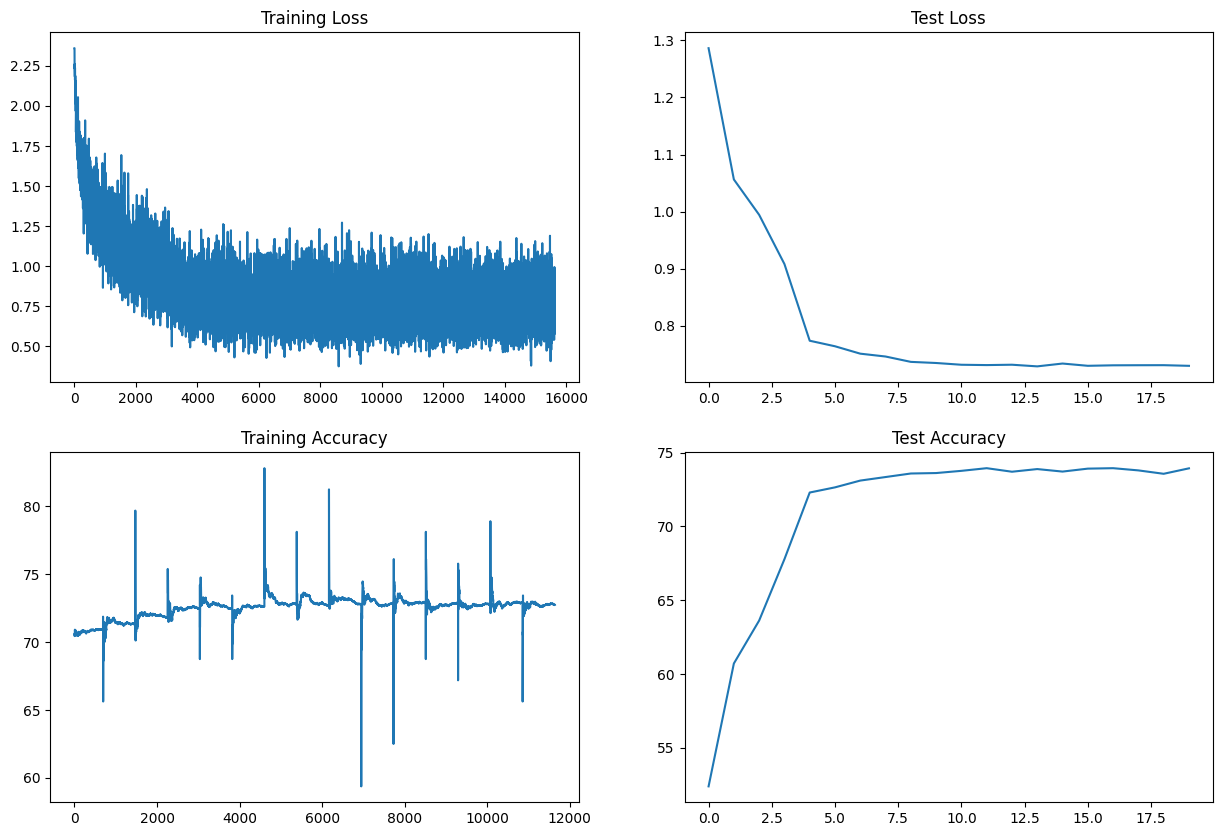

In [12]:
plot_losses(train_losses, train_acc, test_losses, test_acc, "batch_norm")

**********************************************************

# Model Params for Group Normalization
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
m = model.Net_group_norm().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
              ReLU-2           [-1, 48, 32, 32]               0
         GroupNorm-3           [-1, 48, 32, 32]              96
         Dropout2d-4           [-1, 48, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          20,784
              ReLU-6           [-1, 48, 32, 32]               0
         GroupNorm-7           [-1, 48, 32, 32]              96
         Dropout2d-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,568
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,

In [14]:
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1, verbose=False)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(m, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(m, device, test_loader)

EPOCH: 0


100% 782/782 [00:04<00:00, 195.27it/s]

 TRAIN ACCURACY:  35.17 TRAIN LOSS:  1.0761797428131104


 TEST ACCURACY:  44.99 TEST LOSS:  1.4852589227676392
EPOCH: 1


100% 782/782 [00:04<00:00, 194.74it/s]

 TRAIN ACCURACY:  52.316 TRAIN LOSS:  1.5017644166946411


 TEST ACCURACY:  58.59 TEST LOSS:  1.1665339935302734
EPOCH: 2


100% 782/782 [00:04<00:00, 193.99it/s]

 TRAIN ACCURACY:  58.812 TRAIN LOSS:  0.6046037673950195


 TEST ACCURACY:  60.35 TEST LOSS:  1.0807235207557677
EPOCH: 3


100% 782/782 [00:04<00:00, 193.14it/s]

 TRAIN ACCURACY:  63.186 TRAIN LOSS:  0.32801583409309387


 TEST ACCURACY:  64.77 TEST LOSS:  0.9888562678337097
EPOCH: 4


100% 782/782 [00:04<00:00, 189.42it/s]

 TRAIN ACCURACY:  68.37 TRAIN LOSS:  0.42958301305770874


 TEST ACCURACY:  68.67 TEST LOSS:  0.8752167657852172
EPOCH: 5


100% 782/782 [00:04<00:00, 186.04it/s]

 TRAIN ACCURACY:  69.26 TRAIN LOSS:  0.5833584666252136


 TEST ACCURACY:  69.32 TEST LOSS:  0.8571140720367432
EPOCH: 6


100% 782/782 [00:04<00:00, 192.88it/s]

 TRAIN ACCURACY:  69.878 TRAIN LOSS:  1.1612173318862915


 TEST ACCURACY:  70.13 TEST LOSS:  0.8380884914398193
EPOCH: 7


100% 782/782 [00:04<00:00, 193.28it/s]

 TRAIN ACCURACY:  70.102 TRAIN LOSS:  1.0179919004440308


 TEST ACCURACY:  70.41 TEST LOSS:  0.8302001798629761
EPOCH: 8


100% 782/782 [00:04<00:00, 189.05it/s]

 TRAIN ACCURACY:  70.942 TRAIN LOSS:  0.6553962230682373


 TEST ACCURACY:  70.66 TEST LOSS:  0.8221920383453369
EPOCH: 9


100% 782/782 [00:03<00:00, 196.47it/s]

 TRAIN ACCURACY:  71.072 TRAIN LOSS:  0.6510890126228333


 TEST ACCURACY:  70.5 TEST LOSS:  0.8210159389972687
EPOCH: 10


100% 782/782 [00:04<00:00, 188.99it/s]

 TRAIN ACCURACY:  71.534 TRAIN LOSS:  0.9067904353141785


 TEST ACCURACY:  70.79 TEST LOSS:  0.8179003038406372
EPOCH: 11


100% 782/782 [00:04<00:00, 191.04it/s]

 TRAIN ACCURACY:  71.306 TRAIN LOSS:  0.4549705684185028


 TEST ACCURACY:  70.94 TEST LOSS:  0.8181125406265258
EPOCH: 12


100% 782/782 [00:04<00:00, 187.09it/s]

 TRAIN ACCURACY:  71.336 TRAIN LOSS:  0.9038184285163879


 TEST ACCURACY:  70.79 TEST LOSS:  0.8168661457061768
EPOCH: 13


100% 782/782 [00:04<00:00, 181.42it/s]

 TRAIN ACCURACY:  71.478 TRAIN LOSS:  1.1646630764007568


 TEST ACCURACY:  70.85 TEST LOSS:  0.8166576103687286
EPOCH: 14


100% 782/782 [00:04<00:00, 189.87it/s]

 TRAIN ACCURACY:  71.45 TRAIN LOSS:  0.7342314720153809


 TEST ACCURACY:  70.8 TEST LOSS:  0.8165930335044861
EPOCH: 15


100% 782/782 [00:04<00:00, 183.02it/s]

 TRAIN ACCURACY:  71.546 TRAIN LOSS:  0.6351900100708008


 TEST ACCURACY:  70.85 TEST LOSS:  0.8163998013496399
EPOCH: 16


100% 782/782 [00:04<00:00, 189.58it/s]

 TRAIN ACCURACY:  71.55 TRAIN LOSS:  1.012007474899292


 TEST ACCURACY:  70.85 TEST LOSS:  0.8163460074424743
EPOCH: 17


100% 782/782 [00:04<00:00, 186.51it/s]

 TRAIN ACCURACY:  71.412 TRAIN LOSS:  1.1932252645492554


 TEST ACCURACY:  70.83 TEST LOSS:  0.8163121586799622
EPOCH: 18


100% 782/782 [00:04<00:00, 188.26it/s]

 TRAIN ACCURACY:  71.568 TRAIN LOSS:  0.5827242136001587


 TEST ACCURACY:  70.82 TEST LOSS:  0.8162927896499633
EPOCH: 19


100% 782/782 [00:04<00:00, 191.79it/s]

 TRAIN ACCURACY:  71.286 TRAIN LOSS:  0.4526772201061249


 TEST ACCURACY:  70.8 TEST LOSS:  0.8162532158374787


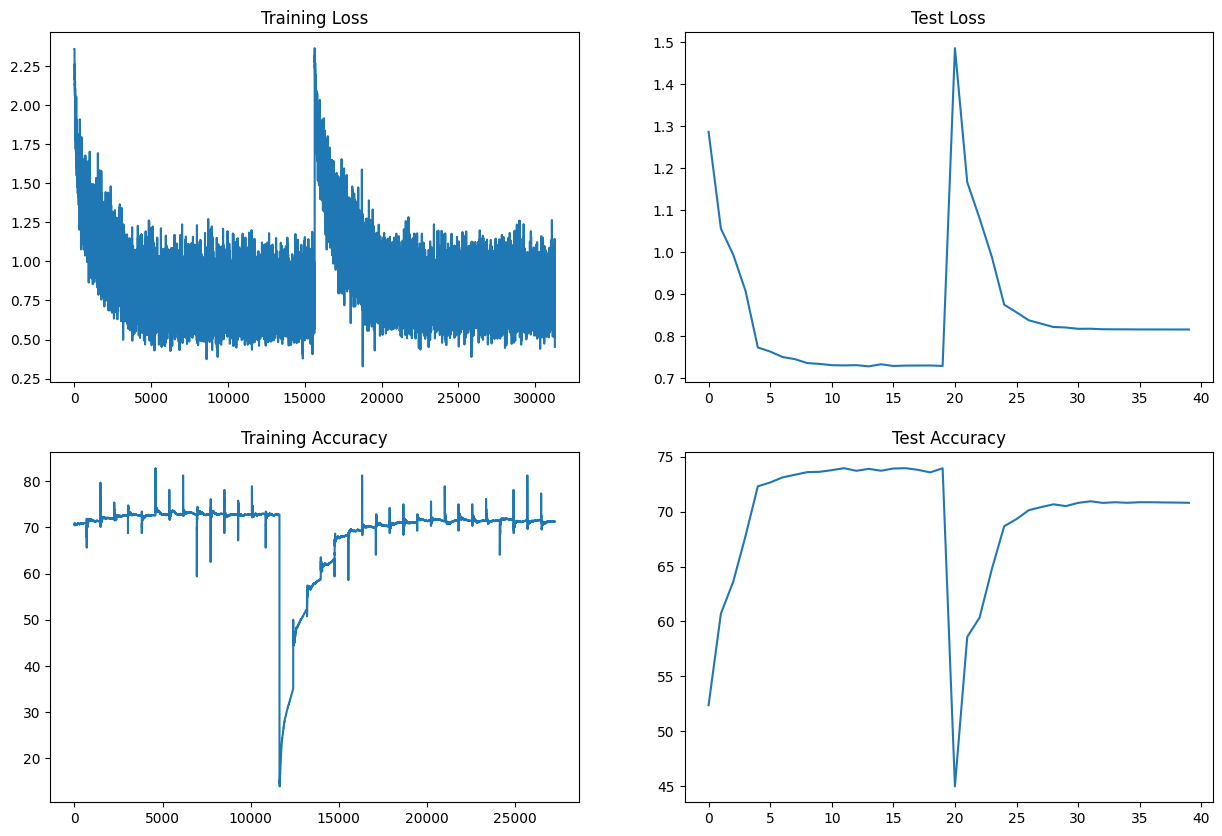

In [15]:
plot_losses(train_losses, train_acc, test_losses, test_acc, "group_norm")

# Model Params for Layer Normalization
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [16]:
m = model.Net_layer_normalization().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             280
              ReLU-2           [-1, 10, 32, 32]               0
         LayerNorm-3           [-1, 10, 32, 32]          20,480
         Dropout2d-4           [-1, 10, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             728
              ReLU-6            [-1, 8, 32, 32]               0
         LayerNorm-7            [-1, 8, 32, 32]          16,384
         Dropout2d-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             144
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11            [-1, 8, 16, 16]           1,160
             ReLU-12            [-1, 8, 16, 16]               0
        LayerNorm-13            [-1, 8, 16, 16]           4,096
        Dropout2d-14            [-1, 8,

In [17]:
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1, verbose=False)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(m, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(m, device, test_loader)

EPOCH: 0


100% 782/782 [00:04<00:00, 179.52it/s]

 TRAIN ACCURACY:  27.5 TRAIN LOSS:  1.5718616247177124


 TEST ACCURACY:  37.48 TEST LOSS:  1.6404984258651734
EPOCH: 1


100% 782/782 [00:04<00:00, 175.00it/s]

 TRAIN ACCURACY:  37.772 TRAIN LOSS:  1.414847731590271


 TEST ACCURACY:  42.13 TEST LOSS:  1.4951860694885253
EPOCH: 2


100% 782/782 [00:04<00:00, 179.18it/s]

 TRAIN ACCURACY:  42.91 TRAIN LOSS:  1.7302658557891846


 TEST ACCURACY:  46.97 TEST LOSS:  1.410850043106079
EPOCH: 3


100% 782/782 [00:04<00:00, 178.19it/s]

 TRAIN ACCURACY:  46.738 TRAIN LOSS:  1.5853127241134644


 TEST ACCURACY:  50.42 TEST LOSS:  1.3286793491363524
EPOCH: 4


100% 782/782 [00:04<00:00, 192.61it/s]

 TRAIN ACCURACY:  50.674 TRAIN LOSS:  0.8237563967704773


 TEST ACCURACY:  52.92 TEST LOSS:  1.2743521307945251
EPOCH: 5


100% 782/782 [00:04<00:00, 187.08it/s]

 TRAIN ACCURACY:  51.18 TRAIN LOSS:  1.7175883054733276


 TEST ACCURACY:  53.25 TEST LOSS:  1.2664372550964356
EPOCH: 6


100% 782/782 [00:04<00:00, 183.56it/s]

 TRAIN ACCURACY:  51.244 TRAIN LOSS:  1.8762531280517578


 TEST ACCURACY:  53.6 TEST LOSS:  1.256652984046936
EPOCH: 7


100% 782/782 [00:04<00:00, 176.45it/s]

 TRAIN ACCURACY:  51.926 TRAIN LOSS:  1.411017656326294


 TEST ACCURACY:  53.75 TEST LOSS:  1.258243111228943
EPOCH: 8


100% 782/782 [00:04<00:00, 185.09it/s]

 TRAIN ACCURACY:  52.17 TRAIN LOSS:  1.2238736152648926


 TEST ACCURACY:  54.25 TEST LOSS:  1.2455723392486573
EPOCH: 9


100% 782/782 [00:04<00:00, 186.37it/s]

 TRAIN ACCURACY:  52.354 TRAIN LOSS:  1.3202881813049316


 TEST ACCURACY:  54.29 TEST LOSS:  1.2439470232009888
EPOCH: 10


100% 782/782 [00:04<00:00, 183.52it/s]

 TRAIN ACCURACY:  52.366 TRAIN LOSS:  1.3405321836471558


 TEST ACCURACY:  54.22 TEST LOSS:  1.2432564434051514
EPOCH: 11


100% 782/782 [00:04<00:00, 187.06it/s]

 TRAIN ACCURACY:  52.436 TRAIN LOSS:  1.4609806537628174


 TEST ACCURACY:  54.36 TEST LOSS:  1.2429708408355713
EPOCH: 12


100% 782/782 [00:04<00:00, 185.41it/s]

 TRAIN ACCURACY:  52.492 TRAIN LOSS:  1.1004177331924438


 TEST ACCURACY:  54.38 TEST LOSS:  1.2424433166503905
EPOCH: 13


100% 782/782 [00:04<00:00, 179.57it/s]

 TRAIN ACCURACY:  52.604 TRAIN LOSS:  1.798365831375122


 TEST ACCURACY:  54.41 TEST LOSS:  1.2418148202896118
EPOCH: 14


100% 782/782 [00:04<00:00, 188.57it/s]

 TRAIN ACCURACY:  52.552 TRAIN LOSS:  1.4046313762664795


 TEST ACCURACY:  54.39 TEST LOSS:  1.2417401401519776
EPOCH: 15


100% 782/782 [00:04<00:00, 181.73it/s]

 TRAIN ACCURACY:  52.448 TRAIN LOSS:  1.175262689590454


 TEST ACCURACY:  54.41 TEST LOSS:  1.2417167877197266
EPOCH: 16


100% 782/782 [00:04<00:00, 186.45it/s]

 TRAIN ACCURACY:  52.502 TRAIN LOSS:  1.3127918243408203


 TEST ACCURACY:  54.41 TEST LOSS:  1.2417019689559936
EPOCH: 17


100% 782/782 [00:04<00:00, 186.40it/s]

 TRAIN ACCURACY:  52.476 TRAIN LOSS:  1.3590697050094604


 TEST ACCURACY:  54.42 TEST LOSS:  1.2417111124038696
EPOCH: 18


100% 782/782 [00:04<00:00, 172.95it/s]

 TRAIN ACCURACY:  52.228 TRAIN LOSS:  1.0667641162872314


 TEST ACCURACY:  54.41 TEST LOSS:  1.2417079475402832
EPOCH: 19


100% 782/782 [00:04<00:00, 184.59it/s]

 TRAIN ACCURACY:  52.47 TRAIN LOSS:  1.2711055278778076


 TEST ACCURACY:  54.43 TEST LOSS:  1.2416964526176453


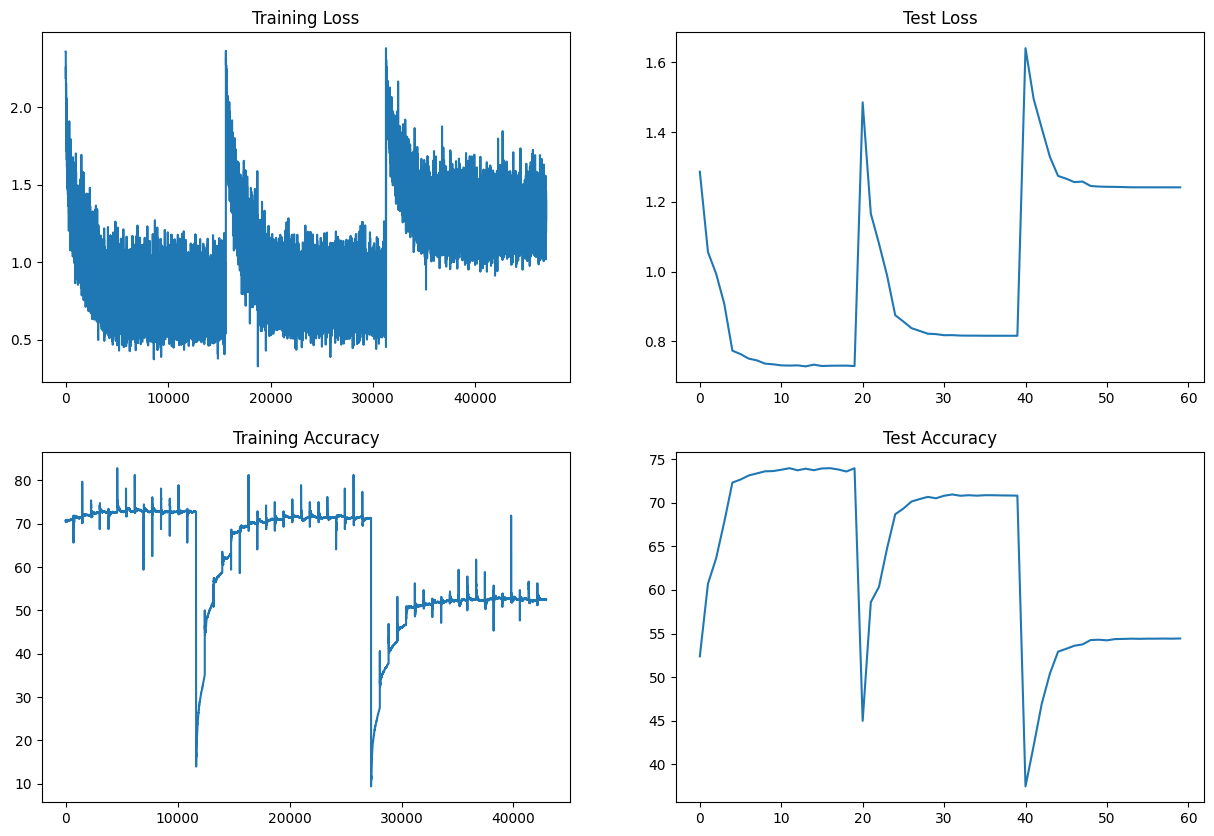

In [18]:
plot_losses(train_losses, train_acc, test_losses, test_acc, "Layer_norm")